# Waveguide Attenuation: Conductor vs Dielectric Loss

This notebook will calculate the waveguide attenuation constant due to conductor loss and dielectric loss.

The values will be calculated based on the approximate properties of an HDPE filled waveguide.

In [1]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
import matplotlib as mpl

# https://github.com/garrettj403/Waveguide
from waveguide import conductor_loss, dielectric_loss
from waveguide import cutoff_frequency, np2db

# https://github.com/garrettj403/SciencePlots
plt.style.use(["science", "notebook"])
mpl.rcParams['mathtext.fontset'] = "dejavusans"

# Waveguide Sizes

WR-28.0:  26.3 to  40.0 GHz, center =  31.6 GHz
WR-22.4:  32.9 to  50.1 GHz, center =  39.5 GHz
WR-18.8:  39.2 to  59.6 GHz, center =  47.1 GHz
WR-14.8:  49.8 to  75.8 GHz, center =  59.8 GHz
WR-12.2:  60.5 to  91.9 GHz, center =  72.6 GHz
WR-10.0:  73.8 to 112.1 GHz, center =  88.5 GHz
WR-6.5 : 113.5 to 172.5 GHz, center = 136.2 GHz
WR-5.1 : 144.6 to 219.9 GHz, center = 173.6 GHz
WR-4.3 : 171.6 to 260.8 GHz, center = 205.9 GHz
WR-3.4 : 217.0 to 329.8 GHz, center = 260.4 GHz
WR-2.8 : 263.5 to 400.5 GHz, center = 316.1 GHz


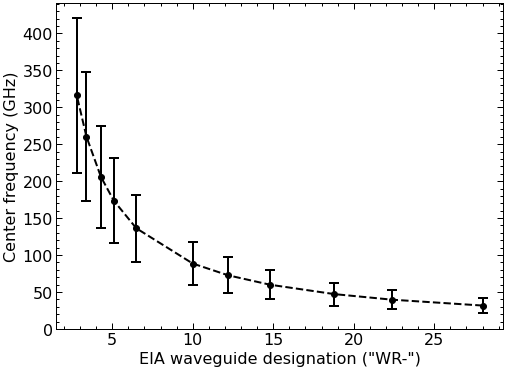

In [2]:
# Waveguide sizes to analyze (EIA designations)
wr_sizes = np.array([28, 22.4, 18.8, 14.8, 12.2, 10, 6.5, 5.1, 4.3, 3.4, 2.8])
f_center = np.empty_like(wr_sizes)
f1 = np.empty_like(wr_sizes)
f2 = np.empty_like(wr_sizes)
dimensions = []

for i, _wr in np.ndenumerate(wr_sizes):
    
    a = _wr * 10 * sc.mil
    b = a / 2
    dimensions.append((a, b))
    
    f1[i] = cutoff_frequency(a, b, m=1, n=0)
    f2[i] = cutoff_frequency(a, b, m=2, n=0)
    f_center[i] = (f1[i] + f2[i]) / 2
    
    wr_name = "WR-{:.1f}".format(_wr)
    print("{:7}: {:5.1f} to {:5.1f} GHz, center = {:5.1f} GHz".format(wr_name, f1[i]*1.25/1e9, f2[i]*0.95/1e9, f_center[i]/1e9))
    
plt.figure()
plt.errorbar(wr_sizes, f_center/1e9, yerr=[(f_center-f1)/1e9, -(f_center-f2)/1e9], c='k', fmt='o', ls='--', capsize=5, capthick=2)
plt.xlabel("EIA waveguide designation (\"WR-\")")
plt.ylabel("Center frequency (GHz)")
plt.ylim(ymin=0)
plt.savefig("results/waveguide-loss-cutoff-frequency.png", dpi=400);

# HDPE

## Conductor Loss

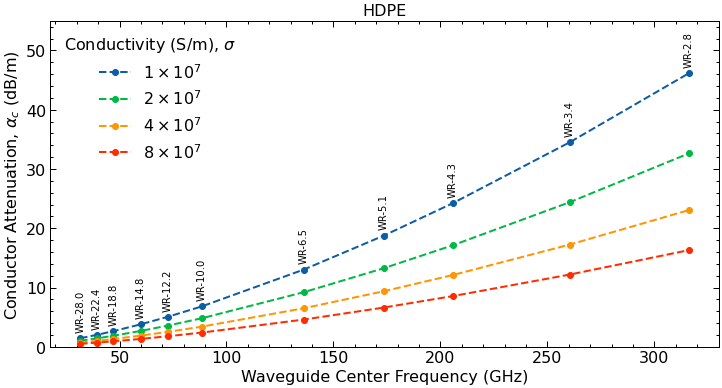

In [3]:
# Relative permittivity
er = 2.3

# Conductivity of waveguide walls
conductivity_list = np.array([1.0e7, 2.0e7, 4.0e7, 8.0e7])

plt.figure(figsize=(12,6))
plt.title("HDPE")
for i, _cond in np.ndenumerate(conductivity_list):
    alpha_c = []
    for _fc, _dim in zip(f_center, dimensions):
        alpha_c.append(conductor_loss(_fc, _cond, _dim[0], _dim[1], er=er))
    alpha_c = np.array(alpha_c)
    plt.plot(f_center/1e9, np2db(alpha_c), marker='o', ls='--', label=r"${:.0f}\times10^7$".format(_cond/1e7))
    if i[0] == 0:
        for _f, _a, _wr in zip(f_center/1e9, np2db(alpha_c), wr_sizes):
            plt.text(_f, _a+1, "WR-{:.1f}".format(_wr), ha='center', va='bottom', rotation=90)
plt.ylabel(r"Conductor Attenuation, $\alpha_c$ (dB/m)")
plt.xlabel("Waveguide Center Frequency (GHz)")
plt.legend(title="Conductivity (S/m), $\sigma$")
plt.ylim([0, 55])
plt.savefig("results/waveguide-loss-hdpe-alphac.png", dpi=400);

## Dielectric Loss

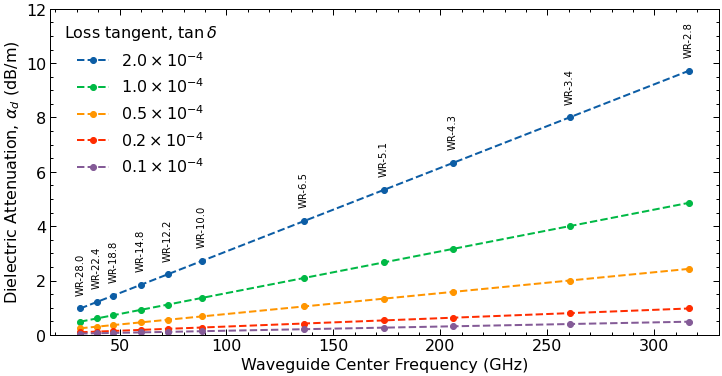

In [4]:
# Relative permittivity
er = 2.3

# Loss tangent
tand_list = [2e-4, 1e-4, 5e-5, 2e-5, 1e-5]

plt.figure(figsize=(12,6))
for i, _tand in np.ndenumerate(tand_list):
    alpha_d = []
    _er = er * (1 - 1j * _tand)
    for _fc, _dim in zip(f_center, dimensions):
        alpha_d.append(dielectric_loss(_fc, _dim[0], b=_dim[1], er=_er))
    alpha_d = np.array(alpha_d)
    plt.plot(f_center/1e9, np2db(alpha_d), marker='o', ls='--', label=r"${:.1f}\times10^{{-4}}$".format(_tand*1e4))
    if i[0] == 0:
        for _f, _a, _wr in zip(f_center/1e9, np2db(alpha_d), wr_sizes):
            plt.text(_f, _a+0.5, "WR-{:.1f}".format(_wr), ha='center', va='bottom', rotation=90)
plt.xlabel("Waveguide Center Frequency (GHz)")
plt.ylabel(r"Dielectric Attenuation, $\alpha_d$ (dB/m)")
plt.ylim([0, 12])
plt.legend(title=r"Loss tangent, $\tan\,\delta$")
plt.savefig("results/waveguide-loss-hdpe-alphad.png", dpi=400);

# Alumina

## Conductor Loss

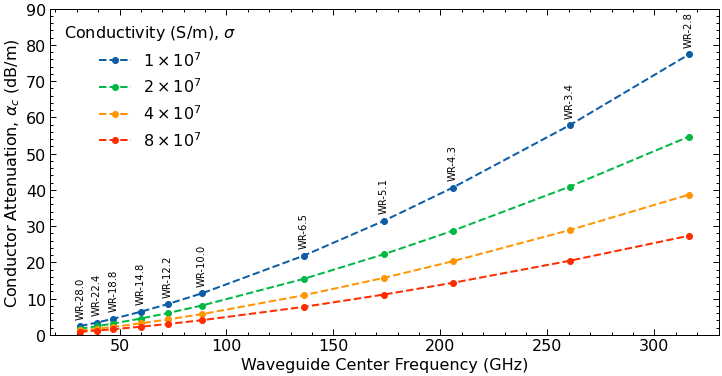

In [5]:
# Relative permittivity
er = 10

# Conductivity of waveguide walls
conductivity_list = np.array([1.0e7, 2.0e7, 4.0e7, 8.0e7])

plt.figure(figsize=(12,6))
for i, _cond in np.ndenumerate(conductivity_list):
    alpha_c = []
    for _fc, _dim in zip(f_center, dimensions):
        alpha_c.append(conductor_loss(_fc, _cond, _dim[0], _dim[1], er=er))
    alpha_c = np.array(alpha_c)
    plt.plot(f_center/1e9, np2db(alpha_c), marker='o', ls='--', label=r"${:.0f}\times10^7$".format(_cond/1e7))
    if i[0] == 0:
        for _f, _a, _wr in zip(f_center/1e9, np2db(alpha_c), wr_sizes):
            plt.text(_f, _a+2, "WR-{:.1f}".format(_wr), ha='center', va='bottom', rotation=90)
plt.ylabel(r"Conductor Attenuation, $\alpha_c$ (dB/m)")
plt.xlabel("Waveguide Center Frequency (GHz)")
plt.legend(title="Conductivity (S/m), $\sigma$")
plt.ylim([0, 90])
plt.savefig("results/waveguide-loss-alumina-alphac.png", dpi=400);

## Dielectric Loss

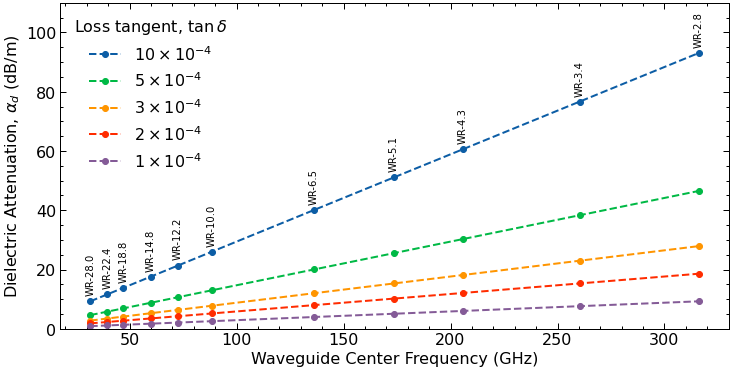

In [6]:
# Relative permittivity
er = 10

# Loss tangent
tand_list = [10e-4, 5e-4, 3e-4, 2e-4, 1e-4]

plt.figure(figsize=(12,6))
for i, _tand in np.ndenumerate(tand_list):
    alpha_d = []
    _er = er * (1 - 1j * _tand)
    for _fc, _dim in zip(f_center, dimensions):
        alpha_d.append(dielectric_loss(_fc, _dim[0], b=_dim[1], er=_er))
    alpha_d = np.array(alpha_d)
    plt.plot(f_center/1e9, np2db(alpha_d), marker='o', ls='--', label=r"${:.0f}\times10^{{-4}}$".format(_tand*1e4))
    if i[0] == 0:
        for _f, _a, _wr in zip(f_center/1e9, np2db(alpha_d), wr_sizes):
            plt.text(_f, _a+2, "WR-{:.1f}".format(_wr), ha='center', va='bottom', rotation=90)
plt.xlabel("Waveguide Center Frequency (GHz)")
plt.ylabel(r"Dielectric Attenuation, $\alpha_d$ (dB/m)")
plt.ylim([0, 110])
plt.legend(title=r"Loss tangent, $\tan\,\delta$")
plt.savefig("results/waveguide-loss-alumina-alphad.png", dpi=400);